# Tonnetz Diffusion

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

In [2]:
cols = ['JSDs'] + [str(i) for i in range(12)] + ['file'] + ['composer'] + ['year']
df = pd.read_csv('results.tsv', sep='\t', names=cols, header=0).sort_values(by='year')
df.head()

,JSDs,0,1,2,3,4,5,6,7,8,9,10,11,file,composer,year
1442,0.082131,0.340914,0.632240,7.403419e-19,3.151637e-03,2.369442e-02,8.765961e-17,0.733203,0.893502,6.852771e-01,0.129920,0.067856,6.137037e-01,..\ExtendedTonality\data\DataFrames\Virtutibus...,Vitry,1361.0
1443,0.062455,0.669057,0.241962,3.861786e-02,9.336871e-13,1.611529e-13,5.036231e-02,0.981455,0.423207,5.527872e-13,0.666220,0.619354,7.413898e-13,..\ExtendedTonality\data\DataFrames\Gratissima...,Vitry,1361.0
1444,0.084306,0.546899,0.453101,1.145053e-16,0.000000e+00,3.797418e-17,0.000000e+00,0.825137,0.881071,4.187719e-01,0.559761,0.378611,1.122226e-01,..\ExtendedTonality\data\DataFrames\Lugentium-...,Vitry,1361.0
1445,0.042667,0.561634,0.438366,4.000629e-17,8.746670e-17,1.521919e-16,7.014793e-17,0.893876,0.771316,3.005533e-01,0.617021,0.441614,8.065462e-02,..\ExtendedTonality\data\DataFrames\Rex-quem-m...,Vitry,1361.0
1400,0.045719,0.526563,0.473437,1.429368e-16,1.485737e-16,9.523765e-18,1.660025e-17,0.886907,0.791428,4.347314e-01,0.485341,0.239210,1.251366e-01,..\ExtendedTonality\data\DataFrames\Messe-de-N...,Machaut,1370.0


## Interval weights

In [3]:
intervals = ['+P5', '-P5', '+m3', '-m3', '+M3', '-m3']

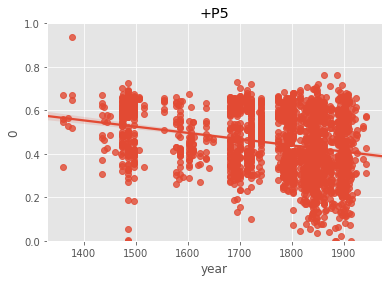

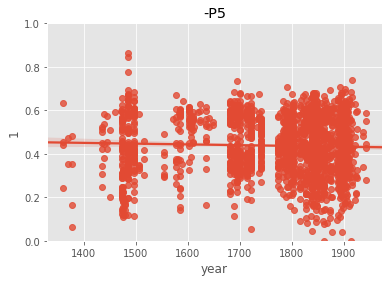

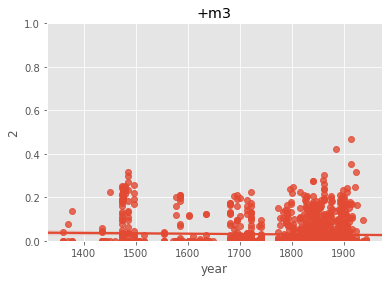

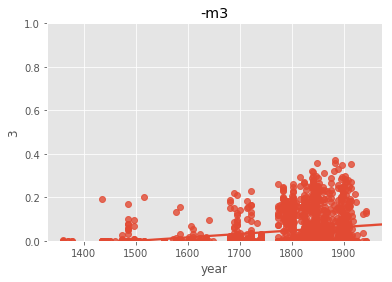

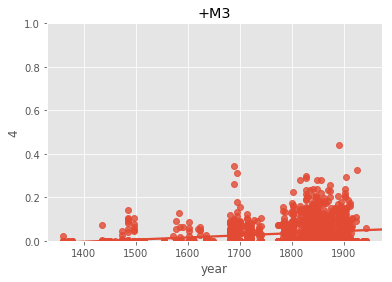

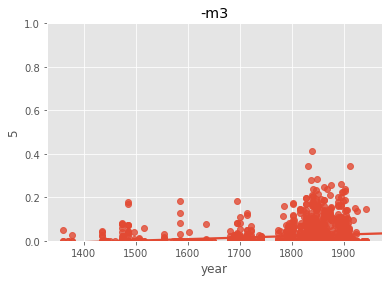

In [16]:
for i, l in zip(range(6), intervals):
    sns.regplot(x='year', y=str(i), data=df[df[str(i)]>0])
    plt.title(str(l))
    plt.ylim(0,1)
    plt.show()

## Interval decays

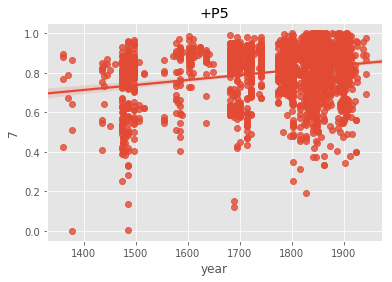

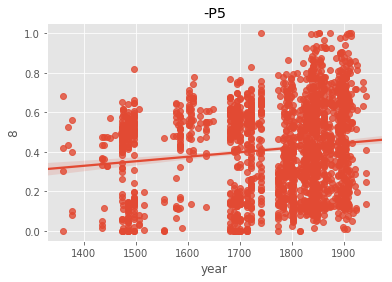

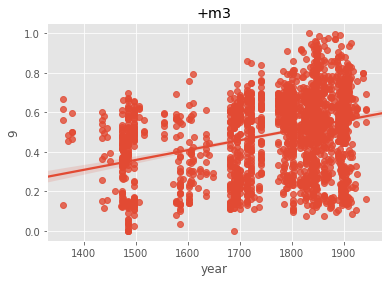

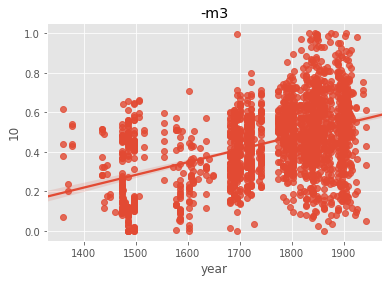

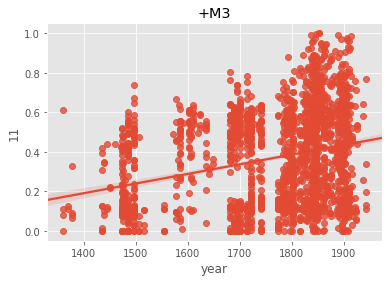

In [17]:
for i, l in zip(range(7,12), intervals):
    sns.regplot(x='year', y=str(i), data=df[df[str(i)]>0])
    plt.title(str(l))
    plt.show()

## Divergences from true distributions per composer

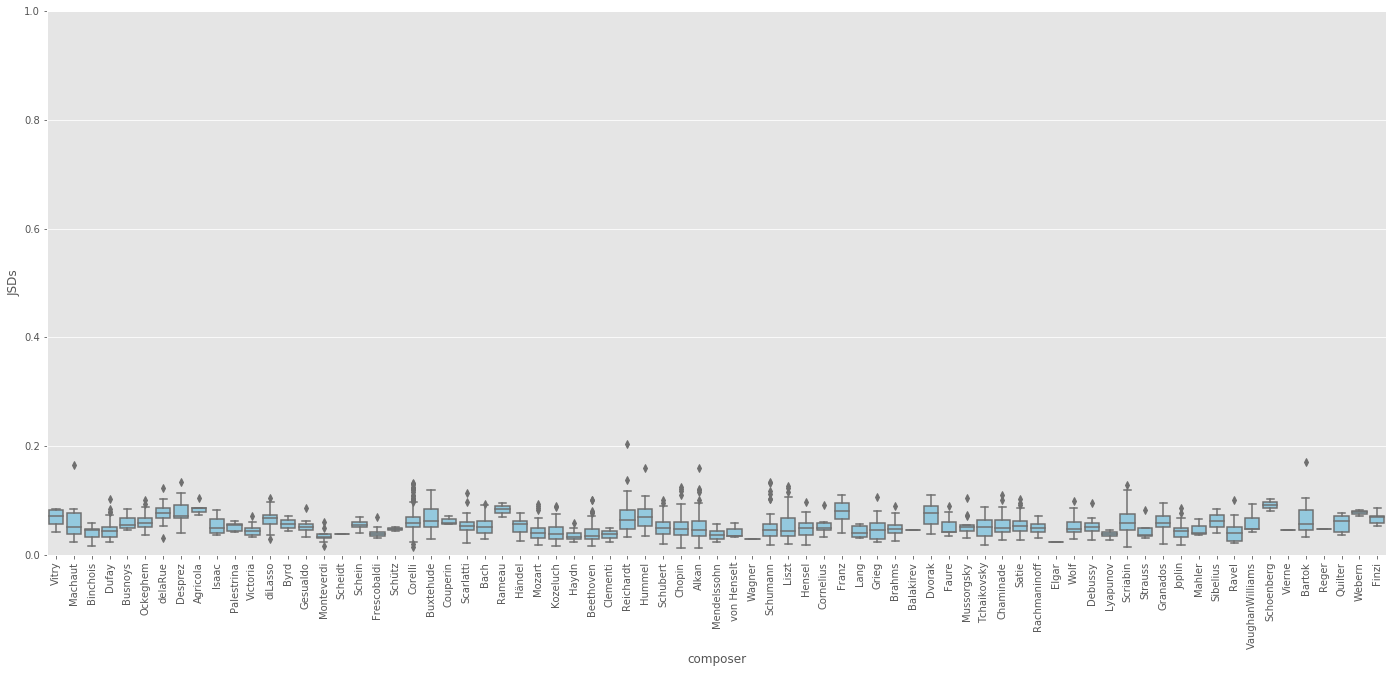

In [20]:
fig, ax = plt.subplots(figsize=(24,10))

sns.boxplot(
    x="composer", 
    y="JSDs",
    color='skyblue',
    data=df, ax=ax)

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.ylim(0,1);